# 1. Variable attachment rate

- Suspended particles move but deposited particles stay in the reactor. 
- Deposited particles are mobilized via dettachment $k_{\rm det}$
- Suspended particles can deposit at rate $k_{\rm att}$, which is a function of CFT.

\begin{equation}
\begin{array}{rcl}
    \dfrac{dnS}{dt} &=& \frac{Q}{V}(S^0 - S) - r_hX_h + k_{\rm hyd}^\mathsf{POCr}\mathsf{POCr} + k_{\rm hyd}^\mathsf{BAP}\mathsf{BAP}\\
    \dfrac{dX_h}{dt} &=& \left(Y'_hr_h - b_h \right)X_h \\    
\end{array}
\end{equation}

In [1]:
import numpy as np
import pandas as pd
import os, subprocess
from scipy.integrate import odeint
from scipy.optimize import fsolve,root
import matplotlib.pyplot as plt

from cftAttachment import CFT

In [2]:
REPO_PATH = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('utf-8').strip()
plt.style.use(f'{REPO_PATH}/misc/edwin.mplstyle')

In [3]:
perm_0, n0 = 1.02E-11 , 0.358 #m2
perm_c, nc = 1.00E-14 , 0.10  #m2

rhoX = 2500.   #mgVSS/L(?)
Xmax = (n0 - nc) * rhoX #mgVSS/L

boolClog = True

def getPerm(n):
    return ((perm_0 - perm_c) * np.power((n-nc)/(n0-nc),3) * np.greater(n - nc,0)) + perm_c;

In [4]:
rho, g, mu = 999.79, 9.81, 0.0008891  #kg/m³, m/s², kg/m.s
head, Lenght, Area = 10., 10., 10.*10. #m,m,m²

def getFlow(n):
    if boolClog:
        perm = getPerm(n)
    else:
        perm = getPerm(n0)
    
    hydCond = perm * rho * g / mu  # m/s
    velFlow = hydCond * head / Lenght         # m/s
    flowRate = velFlow * Area             # m³/s
    Volume = Area * Lenght             # m³
    flow = flowRate/Volume            # 1/s
    #print(f"{k=}, {K=}, {U=}, {Q=}, {V=}")
    return flow*86400     # 1/d

q0 = getFlow(n0)*Lenght/86400
print(f"Init Flowrate: {q0*86400:.3f} m/d")
print(f"Init Flowrate: {q0:.3e} m/s")

Init Flowrate: 9.722 m/d
Init Flowrate: 1.125e-04 m/s


In [18]:
# Attachment/detachment kinetics
cftCalc = CFT(q0,n0,alpha=0.01,debug=False)
katt = cftCalc.katt * 86400  #1/d
kdet = 0.02 #1/d

In [19]:
katt/86400

2.4194453484406767e-05

In [7]:
# Mass inputs
C0 = 100.    #mg/L

## 14.1 Numerical solution.

In [8]:
def CSRT(vec,t):
    C,X = vec
    
    n = n0 - X/rhoX
    clogLimiter = 1.0 - X/Xmax

    flow = getFlow(n)
    
    cftCalc.n = n
    cftCalc.q = flow*Lenght/86400
    katt = cftCalc.katt * 86400

    dC = flow*(C0-C)/n - katt*clogLimiter*C + kdet*X/n
    dX = n*katt*clogLimiter*C - kdet*X
    
    return [dC,dX]

In [9]:
time = np.linspace(0.0001,200,500)
names = ["C","X"]
init =  [C0, 0.0]
tray = odeint(CSRT,init,time)

In [10]:
tray_df = pd.DataFrame({k:v for k,v,i in zip(names,tray.T,init)})
tray_df['Time'] = time
tray_df.set_index('Time',inplace=True)

In [11]:
tray_df["Q"] = getFlow(n0 - tray_df['X']/rhoX)
names.append("Q")

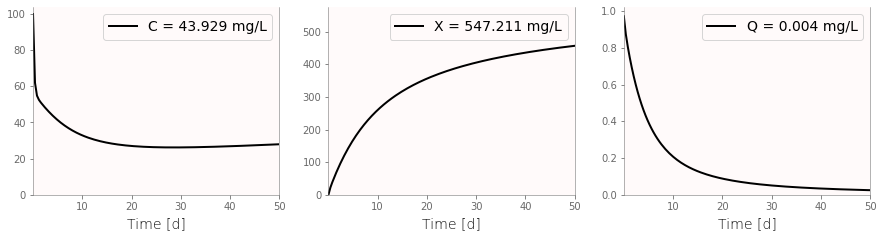

In [12]:
fig,axs = plt.subplots(5,3,figsize=[15,20])
for (name,data),ax in zip(tray_df.iteritems(),axs.flatten()):
    ax.plot(time,data,label='{0} = {1:.3f} mg/L'.format(name,data.iloc[-1]))
    ax.set(xlim=[0.01,50],xlabel="Time [d]")
    ax.set_ylim(bottom=0)
    ax.legend()
[ax.remove() for ax in axs.flatten() if not ax.has_data()]
plt.show()

### 14.2 OpenFOAM implementation 

Using `cloggingFoam`

In [13]:
caseName   = "variableAttachmentRate"
solverFoam = "cloggingFoam"
probeVars  = "suspendedClay depositedClay U"

## Check that solver is compiled
if not(solverFoam in subprocess.run(["which",f"{solverFoam}"],capture_output=True).stdout.decode('utf-8').strip()):
    print("######### SOLVER NOT FOUND ############")

In [14]:
## Run case
os.system(f"cp {REPO_PATH}/misc/probes.tpl {caseName}/system/probes; sed -i 's/<<LIST_OF_VARIABLES_TO_MEASURE>>/({probeVars})/g' {caseName}/system/probes")
os.system(f"cd {caseName}; ./runAll.sh {solverFoam}");

In [15]:
path_case = f"{REPO_PATH}/tests/{solverFoam}/{caseName}/postProcessing/probes/0.000"
probes = os.listdir(path_case)
probes.sort(reverse=True)

In [16]:
results = pd.DataFrame()
for i,probe in enumerate(probes):
    if i == 0:
        results = pd.read_fwf(os.path.join(path_case,probe),
                              widths=[13,14],skiprows=3,
                              names=["Time (s)",str(probe)])
        results.set_index("Time (s)",inplace=True)
    else:
        if probe == "U":
            results = results.join(pd.read_fwf(os.path.join(path_case,probe),
                                               widths=[13,33],skiprows=3,
                                               names=["Time (s)",str(probe)]).set_index("Time (s)"),
                                   on='Time (s)')
            results['U'] = [float(v.split(" ")[-1].replace(")","")) for v in results['U']]
            results['U'] = results['U']*10*10*-86400/(1000*1000)
        
        else:
            results = results.join(pd.read_fwf(os.path.join(path_case,probe),
                                               widths=[13,14],skiprows=3,
                                               names=["Time (s)",str(probe)]).set_index("Time (s)"),
                                   on='Time (s)')

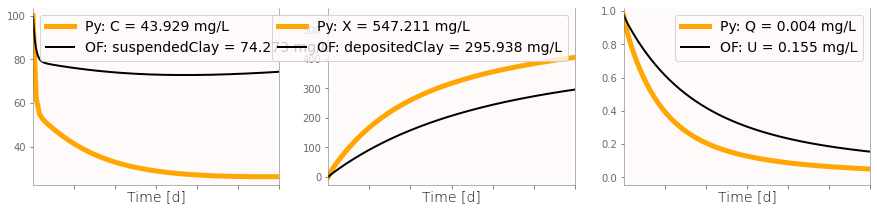

In [17]:
fig,axs = plt.subplots(4,3,figsize=[15,15],sharex=True)
texts = ['suspendedClay', 'depositedClay', 'U', ]
for (name,data),ax,k in zip(tray_df.iteritems(),axs.flatten(),texts):
    ax.plot(time,data,label='Py: {0} = {1:.3f} mg/L'.format(name,data.iloc[-1]),lw=5,alpha=0.99,c='orange')
    ax.plot(results.index/86400.,results[k]*1000.,label='OF: {0} = {1:.3f} mg/L'.format(k,results[k].iloc[-1]*1000.))
    ax.set(xlim=[0.01,30],xlabel="Time [d]")
    #ax.set_ylim(bottom=0)
    ax.legend()
[ax.remove() for ax in axs.flatten() if not ax.has_data()]
plt.show()

In [ ]:
# Clean timesteps
#os.system(f"cd {caseName}; foamListTimes -rm; rm -r dynamicCode VTK log")